In [2]:
import pandas as pd

# Read the data
df = pd.read_csv('../../../../Data/Creation/CSV/Combined_Log_Clean_NoNeg.csv')

df.head()

,date,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx,Real Oil Prices
0,1992-03,8.986886,8.839001,4.024816,13.544280,12.005919,4.134350,4.262926,4.237888,4.394678,...,4.065979,2.478218,2.621766,2.426571,4.330733,11.050763,12.159442,6.619469,2.786412,2.610197
1,1992-04,8.990617,8.841752,4.025655,13.550922,12.011936,4.142042,4.270416,4.245491,4.404083,...,4.069727,2.481568,2.622492,2.430099,4.346399,11.071004,12.159567,6.628021,2.784301,2.674989
2,1992-06,9.000118,8.851692,4.033497,13.552670,12.020207,4.145887,4.273481,4.248251,4.405713,...,4.072355,2.485740,2.630449,2.434490,4.387014,11.051223,12.169043,6.652466,2.691453,2.771428
3,1992-07,8.999322,8.850346,4.036839,13.565973,12.027287,4.154825,4.283439,4.259519,4.418656,...,4.076435,2.484907,2.623218,2.436242,4.338597,11.060620,12.169643,6.666419,2.588035,2.740955
4,1992-11,8.996615,8.847863,4.050880,13.569488,12.049436,4.163143,4.292269,4.269875,4.429636,...,4.087739,2.491551,2.630449,2.441477,4.446174,11.042298,12.193706,6.705386,2.680611,2.661229


## Convert date to year, day so that it can be used in the model.
- Regression models (like random forest) can't use date as a feature. So we convert it to year and day.

In [3]:
# Convert 'date' column to datetime objects
df['date'] = pd.to_datetime(df['date'], format='%Y-%m')

# Extract the year and the month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Find the position of the 'Real Oil Prices' column
real_oil_prices_col_index = df.columns.get_loc('Real Oil Prices')

# Insert 'year' and 'month' columns before 'Real Oil Prices'
df.insert(real_oil_prices_col_index, 'year', df.pop('year'))
df.insert(real_oil_prices_col_index + 1, 'month', df.pop('month'))

# Remove the original 'date' column
df.drop('date', axis=1, inplace=True)

# Display the first few rows of the modified DataFrame
df.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx,year,month,Real Oil Prices
0,8.986886,8.839001,4.024816,13.544280,12.005919,4.134350,4.262926,4.237888,4.394678,4.078063,...,2.621766,2.426571,4.330733,11.050763,12.159442,6.619469,2.786412,1992,3,2.610197
1,8.990617,8.841752,4.025655,13.550922,12.011936,4.142042,4.270416,4.245491,4.404083,4.096502,...,2.622492,2.430099,4.346399,11.071004,12.159567,6.628021,2.784301,1992,4,2.674989
2,9.000118,8.851692,4.033497,13.552670,12.020207,4.145887,4.273481,4.248251,4.405713,4.113261,...,2.630449,2.434490,4.387014,11.051223,12.169043,6.652466,2.691453,1992,6,2.771428
3,8.999322,8.850346,4.036839,13.565973,12.027287,4.154825,4.283439,4.259519,4.418656,4.139407,...,2.623218,2.436242,4.338597,11.060620,12.169643,6.666419,2.588035,1992,7,2.740955
4,8.996615,8.847863,4.050880,13.569488,12.049436,4.163143,4.292269,4.269875,4.429636,4.157180,...,2.630449,2.441477,4.446174,11.042298,12.193706,6.705386,2.680611,1992,11,2.661229


#### 1. Splitting Data into Train and Test Sets

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV

# Split features and target variable
X = df.drop('Real Oil Prices', axis=1)
y = df['Real Oil Prices']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Save the dataset to a CSV file - the dataset RF used to train and test the model

In [5]:
df.to_csv('./RF_Combined_Log_Clean_NoNeg.csv', index=False)

#### 2. Grid Search for Algorithm Tuning

In [6]:
from sklearn.ensemble import RandomForestRegressor

# Hyperparameters grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt']
}

# Initialize the base model
base_rf = RandomForestRegressor(random_state=42)

# Grid search
#  By default, GridSearchCV uses the default scorer of the estimator (in the case of RandomForestRegressor, it's R^2).
grid_search = GridSearchCV(estimator=base_rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print(f"Best Parameters from Grid Search: {best_params}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters from Grid Search: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 200}


#### 3. Creating and Training the Random Forest Regressor and Predict

In [7]:
# Train RF with best parameters
# The ** operator lets us pass a dictionary as keyword arguments
# unpacks the dictionary(best_params) into individual parameters that RF expects
best_rf = RandomForestRegressor(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

# Make predictions
predictions = best_rf.predict(X_test)

## Training Metrics

In [16]:
# Make predictions on the training set
train_predictions = best_rf.predict(X_train)

# Calculate training metrics
train_mae = mean_absolute_error(y_train, train_predictions)
train_mse = mean_squared_error(y_train, train_predictions)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, train_predictions)
train_mape = np.mean(np.abs((y_train - train_predictions) / y_train)) * 100

# Display training metrics
print("\nTraining Metrics:")
print(f"Mean Absolute Error: {train_mae}")
print(f"Mean Squared Error: {train_mse}")
print(f"Root Mean Squared Error: {train_rmse}")
print(f"R^2 Score: {train_r2}")
print(f"Mean Absolute Percentage Error: {train_mape}%")


Training Metrics:
Mean Absolute Error: 0.0324753960334428
Mean Squared Error: 0.0024910720924930484
Root Mean Squared Error: 0.04991064107475528
R^2 Score: 0.985077758879688
Mean Absolute Percentage Error: 1.1446160755400625%


### Evaluation Metrics

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

print("\nModel Evaluation after Grid Search:")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R^2 Score: {r2}")
print(f"MAPE: {mape}")


Model Evaluation after Grid Search:
Mean Absolute Error: 0.043198936613019545
Mean Squared Error: 0.0033275468190876387
Root Mean Squared Error: 0.05768489246837198
R^2 Score: 0.9801234668286969
MAPE: 1.5470225280407932


### Feature Importance

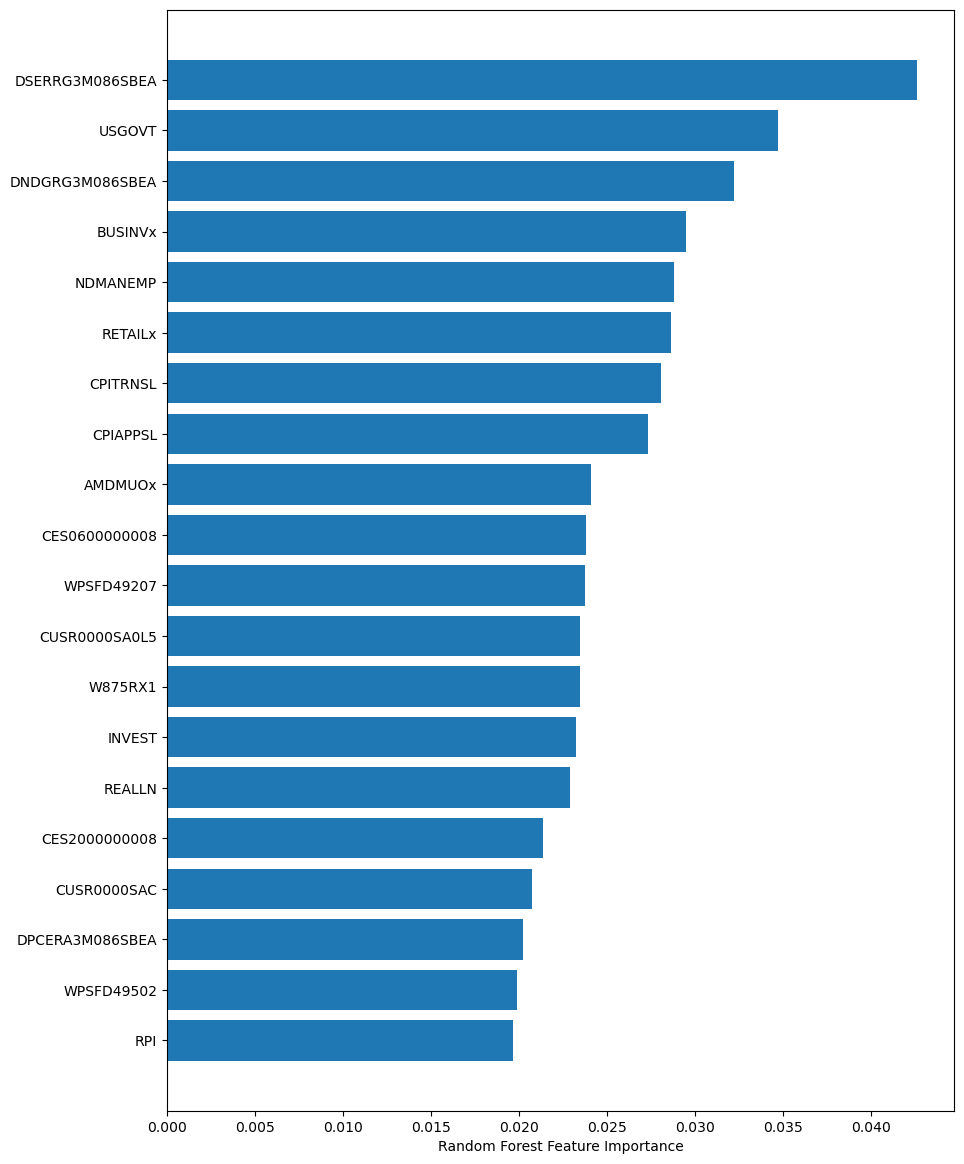

In [9]:
importances = best_rf.feature_importances_
features = X.columns

# Sorting feature importances
sorted_idx = importances.argsort()

# Selecting top 20
top_20_idx = sorted_idx[-20:]

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 12))
plt.barh(range(20), importances[top_20_idx])
plt.yticks(range(20), features[top_20_idx], fontsize=10) 
plt.xlabel("Random Forest Feature Importance")
plt.tight_layout(pad=2) 
plt.show()

In [10]:
### Print out the top 20 features and their importance values
print("\nTop 20 Features:")
for feature in zip(features[top_20_idx], importances[top_20_idx]):
    print(feature)


Top 20 Features:
('RPI', 0.019649801470857563)
('WPSFD49502', 0.019878428761625263)
('DPCERA3M086SBEA', 0.02020819088474023)
('CUSR0000SAC', 0.020717490928310087)
('CES2000000008', 0.02136261728310229)
('REALLN', 0.02290922802143073)
('INVEST', 0.023209225677627475)
('W875RX1', 0.023449632903836434)
('CUSR0000SA0L5', 0.023459002707161152)
('WPSFD49207', 0.023724101843705894)
('CES0600000008', 0.023803313434927406)
('AMDMUOx', 0.024087516673942197)
('CPIAPPSL', 0.027326352064153552)
('CPITRNSL', 0.02807866309862326)
('RETAILx', 0.028620501465086642)
('NDMANEMP', 0.028803804703034647)
('BUSINVx', 0.0294497703737016)
('DNDGRG3M086SBEA', 0.03218898617093086)
('USGOVT', 0.034696500082362663)
('DSERRG3M086SBEA', 0.04258571212078724)


### Learning Curve Attempt

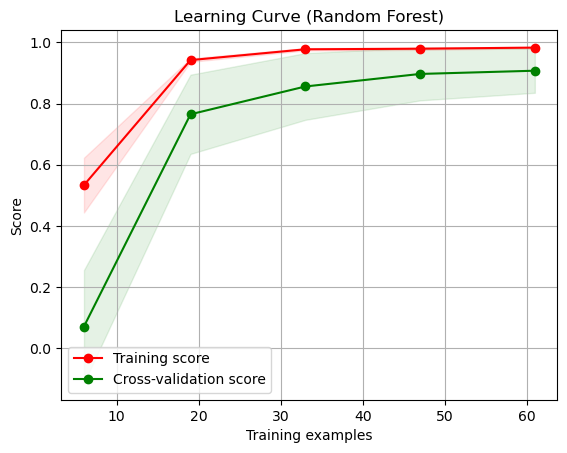

In [11]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

plot_learning_curve(best_rf, "Learning Curve (Random Forest)", X_train, y_train, cv=5)
plt.show()

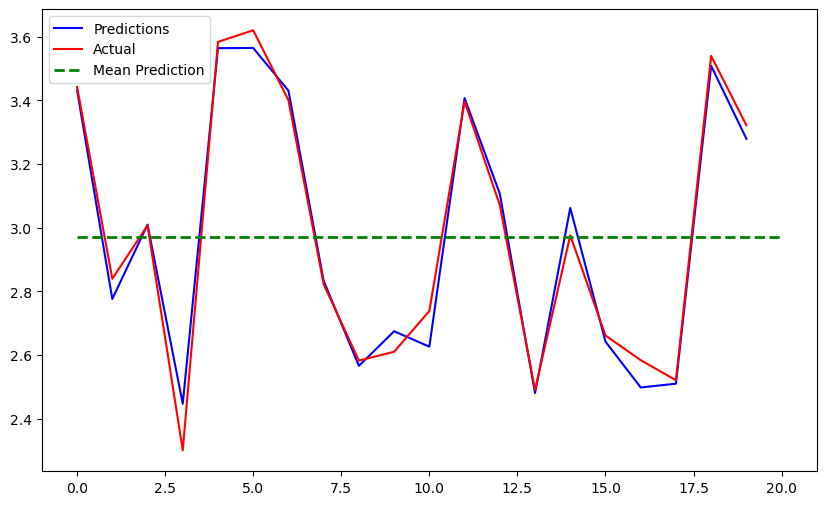

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(predictions, label='Predictions', color='blue')
plt.plot(y_test.values, label='Actual', color='red')

# Mean Prediction line
plt.plot([0, len(y_test)], [predictions.mean(), predictions.mean()], '--', lw=2, color='green', label='Mean Prediction')

plt.legend(loc='upper left')
plt.show()

### Cross Validation

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Cross-validation for R^2
cv_r2 = cross_val_score(best_rf, X, y, cv=5, scoring='r2')
print(f"CV R^2 scores: {cv_r2}")
print(f"Average R^2 score: {np.mean(cv_r2)}")

# Cross-validation for MAE
cv_mae = cross_val_score(best_rf, X, y, cv=5, scoring='neg_mean_absolute_error')
cv_mae = -cv_mae  # Negating the scores to get positive values
print(f"CV MAE scores: {cv_mae}")
print(f"Average MAE score: {np.mean(cv_mae)}")

# Cross-validation for MSE
cv_mse = cross_val_score(best_rf, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse = -cv_mse  # Negating the scores to get positive values
print(f"CV MSE scores: {cv_mse}")
print(f"Average MSE score: {np.mean(cv_mse)}")

# Cross-validation for RMSE
cv_rmse = np.sqrt(cv_mse)
print(f"CV RMSE scores: {cv_rmse}")
print(f"Average RMSE score: {np.mean(cv_rmse)}")

# Cross-validation for MAPE
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Creating a scorer for MAPE
mape_scorer = make_scorer(mape, greater_is_better=False)

cv_mape = cross_val_score(best_rf, X, y, cv=5, scoring=mape_scorer)
cv_mape = -cv_mape  # Negating the scores to get positive values
print(f"CV MAPE scores: {cv_mape}")
print(f"Average MAPE score: {np.mean(cv_mape)}")

# Standard deviation of the target variable
std_dev = y.std()
print(f"Standard Deviation of the target variable: {std_dev}")

# Standard deviation of RMSE
std_rmse = cv_rmse.std()
print(f"Standard Deviation of RMSE: {std_rmse}")

CV R^2 scores: [ 0.18792476  0.09831655  0.53237333 -0.09672242  0.17766859]
Average R^2 score: 0.17991216145220473
CV MAE scores: [0.10221432 0.09438511 0.11587152 0.1780302  0.24478778]
Average MAE score: 0.14705778619886717
CV MSE scores: [0.0168215  0.01608695 0.01648834 0.0412776  0.07833179]
Average MSE score: 0.033801234699258574
CV RMSE scores: [0.12969772 0.12683434 0.12840694 0.20316889 0.27987816]
Average RMSE score: 0.1735972096855795
CV MAPE scores: [4.15487528 3.6192736  3.79586962 5.50507003 7.76010902]
Average MAPE score: 4.967039509229989
Standard Deviation of the target variable: 0.4108234237341301
Standard Deviation of RMSE: 0.06054125443562864


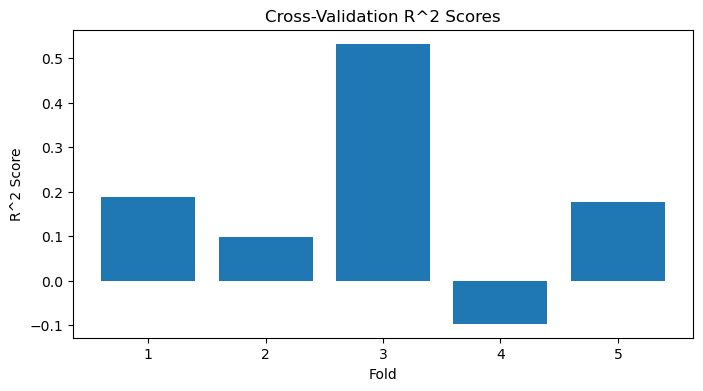

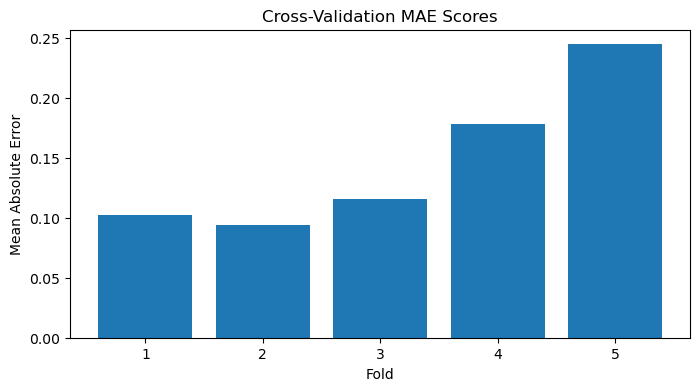

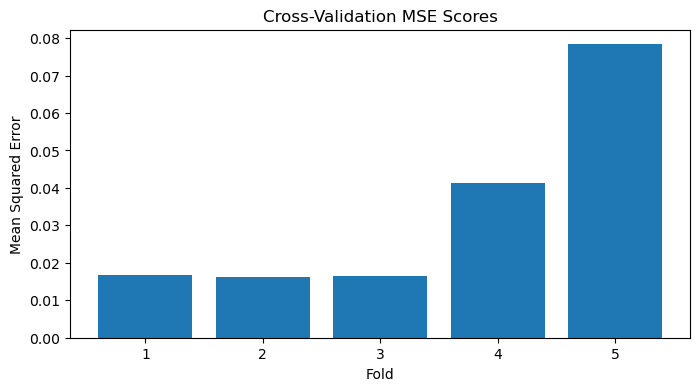

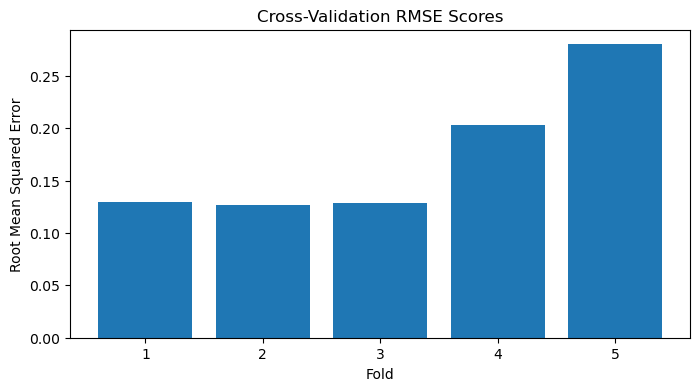

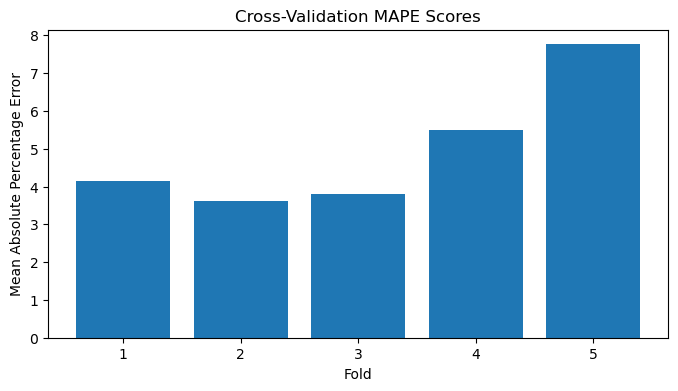

In [14]:

# Plotting CV R^2 scores
plt.figure(figsize=(8, 4))
plt.bar(range(1, len(cv_r2) + 1), cv_r2)
plt.xlabel('Fold')
plt.ylabel('R^2 Score')
plt.title('Cross-Validation R^2 Scores')
plt.show()

# Plotting CV MAE scores
plt.figure(figsize=(8, 4))
plt.bar(range(1, len(cv_mae) + 1), cv_mae)
plt.xlabel('Fold')
plt.ylabel('Mean Absolute Error')
plt.title('Cross-Validation MAE Scores')
plt.show()

# Plotting CV MSE scores
plt.figure(figsize=(8, 4))
plt.bar(range(1, len(cv_mse) + 1), cv_mse)
plt.xlabel('Fold')
plt.ylabel('Mean Squared Error')
plt.title('Cross-Validation MSE Scores')
plt.show()

# Plotting CV RMSE scores
plt.figure(figsize=(8, 4))
plt.bar(range(1, len(cv_rmse) + 1), cv_rmse)
plt.xlabel('Fold')
plt.ylabel('Root Mean Squared Error')
plt.title('Cross-Validation RMSE Scores')
plt.show()

# Plotting CV MAPE scores
plt.figure(figsize=(8, 4))
plt.bar(range(1, len(cv_mape) + 1), cv_mape)
plt.xlabel('Fold')
plt.ylabel('Mean Absolute Percentage Error')
plt.title('Cross-Validation MAPE Scores')
plt.show()

### Random Forest gave the 'best' metrics when used on this dataset...
So, we will be picking this model to be used in the web interface.


### Joblib - we will be using joblib instead of pickle to save the model because it is more efficient on objects that carry large numpy arrays internally as is the case for fitted scikit-learn estimators.

In [15]:
import joblib

# Save the model to a file
joblib.dump(best_rf, 'random_forest_model.pkl')

['random_forest_model.pkl']